In [21]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
import math
import time

# create lstm models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# hyperparameter tuning
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping, Callback

# 1-Load Data

In [2]:
# load interim data set
data_set = pd.read_csv('../data/processed/international-airline-passengers.csv')
data_set

,passenger_number,month,previous_passenger_number
0,118.0,2,112.0
1,132.0,3,118.0
2,129.0,4,132.0
3,121.0,5,129.0
4,135.0,6,121.0
...,...,...,...
138,606.0,8,622.0
139,508.0,9,606.0
140,461.0,10,508.0
141,390.0,11,461.0


# 2-Perform Train, Validation (2 years), Test Split (2 years)

In [10]:
train_size = len(data_set) - 48
validation_size = 24
test_size = 24
train_set, validation_set, test_set = data_set[0:train_size+1], data_set[train_size:train_size+validation_size], data_set[train_size+validation_size:]
print(f"Training set: {len(train_set)}, validation set: {len(validation_set)}, test set: {len(test_set)}")

Training set: 96, validation set: 24, test set: 24


# 3-Normalize Data

In [18]:
# get the columns that have to be normalized
i = 0
temp = train_set.drop(columns="passenger_number")
for col in temp.columns:
    print(i)
    print(col)
    i = i + 1

0
month
1
previous_passenger_number


In [19]:
features_to_normalize = [0, 1]

In [23]:
def normalize_lookahead(train_set, validation_set, test_set, features_to_normalize):
    passenger_number_normalized = []
    all_features_normalized = []
    
    # fit & save demand scaler in order to denormalize predictions later on
    passenger_number_scaler = MinMaxScaler(feature_range=(0, 1))
    passenger_number_train = train_set['passenger_number'].values.reshape(len(train_set), 1)
    passenger_number_scaler = passenger_number_scaler.fit(passenger_number_train)
    
    # normalize passenger_number
    passenger_number_val =  validation_set['passenger_number'].values.reshape(len(validation_set), 1)
    passenger_number_test = test_set['passenger_number'].values.reshape(len(test_set), 1)

    passenger_number_normalized_train = passenger_number_scaler.transform(passenger_number_train)
    passenger_number_normalized.append(passenger_number_normalized_train)
    
    passenger_number_normalized_val = passenger_number_scaler.transform(passenger_number_val)
    passenger_number_normalized.append(passenger_number_normalized_val)
    
    passenger_number_normalized_test = passenger_number_scaler.transform(passenger_number_test)
    passenger_number_normalized.append(passenger_number_normalized_test)
    
    
    # fit & save a scaler for all features
    all_features_scaler = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('mm', MinMaxScaler(feature_range=(0, 1)) , features_to_normalize)
        ])
    
    # reshape train set
    temp_train = train_set.drop(columns=["passenger_number"])
    train_reshaped_df = temp_train.values.reshape((len(temp_train), len(temp_train.columns)))
    
    # fit & save the scaler for all features
    all_features_scaler = all_features_scaler.fit(train_reshaped_df)
    
    # normalize train set
    normalized_train_set = all_features_scaler.transform(train_reshaped_df)
    all_features_normalized.append(normalized_train_set)
    
    # reshape & normalize validation set
    temp_val = validation_set.drop(columns=["passenger_number"])
    val_reshaped_df = temp_val.values.reshape((len(temp_val), len(temp_val.columns)))
    normalized_val_set = all_features_scaler.transform(val_reshaped_df)
    all_features_normalized.append(normalized_val_set)
    
    # reshape & normalize test set
    temp_test = test_set.drop(columns=["passenger_number"])
    test_reshaped_df = temp_test.values.reshape((len(temp_test), len(temp_test.columns)))
    normalized_test_set = all_features_scaler.transform(test_reshaped_df)
    all_features_normalized.append(normalized_test_set)
    
    return passenger_number_scaler, passenger_number_normalized, all_features_normalized

In [24]:
passenger_number_scaler, passenger_number_normalized, all_features_normalized = normalize_lookahead(train_set, validation_set, test_set, features_to_normalize)

# 4-Create samples using Moving Window Technique

In [29]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1] #[lookahead]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [31]:
def create_samples(passenger_number_normalized, all_features_normalized, input_window_size, output_window_size):
    train_set = np.hstack((all_features_normalized[0], passenger_number_normalized[0]))
    train_samples = split_sequences(train_set, input_window_size, output_window_size)
    
    val_set = np.hstack((all_features_normalized[1], passenger_number_normalized[1]))
    val_samples = split_sequences(val_set, input_window_size, output_window_size)
    
    test_set = np.hstack((all_features_normalized[2], passenger_number_normalized[2]))
    test_samples = split_sequences(test_set, input_window_size, output_window_size)

    print(f"Number of training samples: {len(train_samples[0])}, validation samples: {len(val_samples[0])}, test samples: {len(test_samples[0])}")
    return train_samples, val_samples, test_samples

## Let's set size of the input window width to 6 since this was the best performing size for the univariate model

In [32]:
input_window_size = 6
output_window_size = 1

train_samples, val_samples, test_samples = create_samples(passenger_number_normalized, all_features_normalized, input_window_size, output_window_size)

Number of training samples: 91, validation samples: 19, test samples: 19


In [38]:
# summarize samples for a single product
X = train_samples[0]
y = train_samples[1]
n_features = X.shape[2]

print(n_features)
print(X.shape)
print(y.shape)

for i in range(len(X)):
    print(X[i], y[i])

2
(91, 6, 2)
(91, 1)
[[0.09090909 0.02588997]
 [0.18181818 0.04530744]
 [0.27272727 0.09061489]
 [0.36363636 0.08090615]
 [0.45454545 0.05501618]
 [0.54545455 0.10032362]] [0.14239482]
[[0.18181818 0.04530744]
 [0.27272727 0.09061489]
 [0.36363636 0.08090615]
 [0.45454545 0.05501618]
 [0.54545455 0.10032362]
 [0.63636364 0.14239482]] [0.14239482]
[[0.27272727 0.09061489]
 [0.36363636 0.08090615]
 [0.45454545 0.05501618]
 [0.54545455 0.10032362]
 [0.63636364 0.14239482]
 [0.72727273 0.14239482]] [0.10355987]
[[0.36363636 0.08090615]
 [0.45454545 0.05501618]
 [0.54545455 0.10032362]
 [0.63636364 0.14239482]
 [0.72727273 0.14239482]
 [0.81818182 0.10355987]] [0.04854369]
[[0.45454545 0.05501618]
 [0.54545455 0.10032362]
 [0.63636364 0.14239482]
 [0.72727273 0.14239482]
 [0.81818182 0.10355987]
 [0.90909091 0.04854369]] [0.]
[[0.54545455 0.10032362]
 [0.63636364 0.14239482]
 [0.72727273 0.14239482]
 [0.81818182 0.10355987]
 [0.90909091 0.04854369]
 [1.         0.        ]] [0.04530744]
[[0

 [0.63636364 0.51779935]] [0.54368932]
[[0.27272727 0.42718447]
 [0.36363636 0.42394822]
 [0.45454545 0.40453074]
 [0.54545455 0.44983819]
 [0.63636364 0.51779935]
 [0.72727273 0.54368932]] [0.43042071]
[[0.36363636 0.42394822]
 [0.45454545 0.40453074]
 [0.54545455 0.44983819]
 [0.63636364 0.51779935]
 [0.72727273 0.54368932]
 [0.81818182 0.43042071]] [0.34627832]
[[0.45454545 0.40453074]
 [0.54545455 0.44983819]
 [0.63636364 0.51779935]
 [0.72727273 0.54368932]
 [0.81818182 0.43042071]
 [0.90909091 0.34627832]] [0.24595469]
[[0.54545455 0.44983819]
 [0.63636364 0.51779935]
 [0.72727273 0.54368932]
 [0.81818182 0.43042071]
 [0.90909091 0.34627832]
 [1.         0.24595469]] [0.31391586]
[[0.63636364 0.51779935]
 [0.72727273 0.54368932]
 [0.81818182 0.43042071]
 [0.90909091 0.34627832]
 [1.         0.24595469]
 [0.         0.31391586]] [0.3236246]
[[0.72727273 0.54368932]
 [0.81818182 0.43042071]
 [0.90909091 0.34627832]
 [1.         0.24595469]
 [0.         0.31391586]
 [0.09090909 0.32

# 5-Network Architecture

In [39]:
def build_model(hp):
    model = Sequential()
    # input LSTM layer
    model.add(LSTM(hp.Int("input_units", min_value=5, max_value=50, step=3),
                   activation='relu', input_shape=(input_window_size, n_features), name="lstm"))
    
    # dense hidden layers with dropouts
    for i in range(hp.Int("n_layers", 0,2)):
        model.add(Dense(hp.Int(f"dense_{i}_units", min_value=5, max_value=50, step=3),
                        activation='relu', name=f"hidden_{i}"))
        for j in range(hp.Int("dropout_layers", 0, 1)):
            model.add(Dropout(hp.Choice(f"drop_rate_{j}", values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), name=f"dropout_{i}{j}"))
    
    # dense output layer
    model.add(Dense(output_window_size, name="output"))
    # add support for decay=hp.Choice("decay", values=[])) if SGD used
    model.compile(loss='mse' , optimizer=Adam(learning_rate=
            hp.Choice("learning_rate",values=[1e-2, 1e-3, 1e-4])), metrics=[metrics.mae])
    return model

In [40]:
approach = "multivariate"

# training & hyperparameter tuning
LOG_DIR = f"{int((time.time()))}"

tuner = RandomSearch(
        build_model,
        objective="val_mean_absolute_error", # evtl. RMSE
        max_trials= 5,
        executions_per_trial=3,
        directory='one_step_univariate/tuning_logs',
        project_name=LOG_DIR
    )
    
tuner.search(
    x=train_samples[0],
    y=train_samples[1],
    epochs=100,
    batch_size=32,
    validation_data=(val_samples[0], val_samples[1]),
    callbacks=[EarlyStopping('val_loss', patience=5)])
    
# get best model
model = tuner.get_best_models(num_models=1)[0]
model.save(f"../models/{approach}_{input_window_size}")

Train on 91 samples, validate on 19 samples
Epoch 1/100
91/91 [==============================] - ETA: 2s - loss: 0.1311 - mean_absolute_error: 0.288 - 2s 20ms/sample - loss: 0.1129 - mean_absolute_error: 0.2672 - val_loss: 0.2802 - val_mean_absolute_error: 0.4720
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.155 - 0s 1ms/sample - loss: 0.0550 - mean_absolute_error: 0.1920 - val_loss: 0.0959 - val_mean_absolute_error: 0.2617
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.217 - 0s 1ms/sample - loss: 0.0468 - mean_absolute_error: 0.1827 - val_loss: 0.1509 - val_mean_absolute_error: 0.3145
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.0198 - mean_absolute_error: 0.120 - 0s 1ms/sample - loss: 0.0340 - mean_absolute_error: 0.1474 - val_loss: 0.1858 - val_mean_absolute_error: 0.3692
Epoch 5/100
91/91 [==============================] - ETA: 0s - loss: 0.0288 - m

Epoch 13/100
91/91 [==============================] - ETA: 0s - loss: 0.0061 - mean_absolute_error: 0.064 - 0s 1ms/sample - loss: 0.0083 - mean_absolute_error: 0.0724 - val_loss: 0.0395 - val_mean_absolute_error: 0.1688
Epoch 14/100
91/91 [==============================] - ETA: 0s - loss: 0.0083 - mean_absolute_error: 0.070 - 0s 725us/sample - loss: 0.0106 - mean_absolute_error: 0.0822 - val_loss: 0.0397 - val_mean_absolute_error: 0.1681
Epoch 15/100
91/91 [==============================] - ETA: 0s - loss: 0.0077 - mean_absolute_error: 0.070 - 0s 1ms/sample - loss: 0.0075 - mean_absolute_error: 0.0684 - val_loss: 0.0925 - val_mean_absolute_error: 0.2371
Epoch 16/100
91/91 [==============================] - ETA: 0s - loss: 0.0106 - mean_absolute_error: 0.070 - 0s 877us/sample - loss: 0.0078 - mean_absolute_error: 0.0660 - val_loss: 0.0698 - val_mean_absolute_error: 0.2093
Epoch 17/100
91/91 [==============================] - ETA: 0s - loss: 0.0096 - mean_absolute_error: 0.071 - 0s 1ms/s

Epoch 23/100
91/91 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.053 - 0s 929us/sample - loss: 0.0050 - mean_absolute_error: 0.0566 - val_loss: 0.0206 - val_mean_absolute_error: 0.1194
Epoch 24/100
91/91 [==============================] - ETA: 0s - loss: 0.0044 - mean_absolute_error: 0.053 - 0s 1ms/sample - loss: 0.0042 - mean_absolute_error: 0.0520 - val_loss: 0.0314 - val_mean_absolute_error: 0.1493
Epoch 25/100
91/91 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.048 - 0s 1ms/sample - loss: 0.0052 - mean_absolute_error: 0.0564 - val_loss: 0.0258 - val_mean_absolute_error: 0.1344
Epoch 26/100
91/91 [==============================] - ETA: 0s - loss: 0.0048 - mean_absolute_error: 0.057 - 0s 1ms/sample - loss: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0181 - val_mean_absolute_error: 0.1137
Epoch 27/100
91/91 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.063 - 0s 849us/s

Train on 91 samples, validate on 19 samples
Epoch 1/100
91/91 [==============================] - ETA: 2s - loss: 0.2362 - mean_absolute_error: 0.422 - 2s 22ms/sample - loss: 0.2136 - mean_absolute_error: 0.3971 - val_loss: 0.8995 - val_mean_absolute_error: 0.9270
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.1863 - mean_absolute_error: 0.361 - 0s 2ms/sample - loss: 0.1857 - mean_absolute_error: 0.3612 - val_loss: 0.8201 - val_mean_absolute_error: 0.8827
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.2036 - mean_absolute_error: 0.381 - 0s 1ms/sample - loss: 0.1629 - mean_absolute_error: 0.3328 - val_loss: 0.7442 - val_mean_absolute_error: 0.8382
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.1656 - mean_absolute_error: 0.315 - 0s 976us/sample - loss: 0.1427 - mean_absolute_error: 0.3073 - val_loss: 0.6761 - val_mean_absolute_error: 0.7960
Epoch 5/100
91/91 [==============================] - ETA: 0s - loss: 0.1200 -

Epoch 38/100
91/91 [==============================] - ETA: 0s - loss: 0.0076 - mean_absolute_error: 0.069 - 0s 2ms/sample - loss: 0.0067 - mean_absolute_error: 0.0611 - val_loss: 0.0427 - val_mean_absolute_error: 0.1780
Epoch 39/100
91/91 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.050 - ETA: 0s - loss: 0.0062 - mean_absolute_error: 0.059 - 0s 2ms/sample - loss: 0.0065 - mean_absolute_error: 0.0610 - val_loss: 0.0397 - val_mean_absolute_error: 0.1671
Epoch 40/100
91/91 [==============================] - ETA: 0s - loss: 0.0080 - mean_absolute_error: 0.066 - 0s 1ms/sample - loss: 0.0064 - mean_absolute_error: 0.0612 - val_loss: 0.0391 - val_mean_absolute_error: 0.1677
Epoch 41/100
91/91 [==============================] - ETA: 0s - loss: 0.0043 - mean_absolute_error: 0.051 - 0s 1ms/sample - loss: 0.0061 - mean_absolute_error: 0.0598 - val_loss: 0.0397 - val_mean_absolute_error: 0.1712
Epoch 42/100
91/91 [==============================] - ETA: 0s - lo

Epoch 10/100
91/91 [==============================] - ETA: 0s - loss: 0.0246 - mean_absolute_error: 0.137 - 0s 2ms/sample - loss: 0.0313 - mean_absolute_error: 0.1433 - val_loss: 0.1194 - val_mean_absolute_error: 0.2669
Epoch 11/100
91/91 [==============================] - ETA: 0s - loss: 0.0210 - mean_absolute_error: 0.116 - 0s 2ms/sample - loss: 0.0301 - mean_absolute_error: 0.1437 - val_loss: 0.0993 - val_mean_absolute_error: 0.2406
Epoch 12/100
91/91 [==============================] - ETA: 0s - loss: 0.0253 - mean_absolute_error: 0.134 - 0s 1ms/sample - loss: 0.0304 - mean_absolute_error: 0.1460 - val_loss: 0.0893 - val_mean_absolute_error: 0.2366
Epoch 13/100
91/91 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.145 - 0s 1ms/sample - loss: 0.0288 - mean_absolute_error: 0.1425 - val_loss: 0.0872 - val_mean_absolute_error: 0.2337
Epoch 14/100
91/91 [==============================] - ETA: 0s - loss: 0.0266 - mean_absolute_error: 0.141 - 0s 2ms/sampl

Epoch 15/100
91/91 [==============================] - ETA: 0s - loss: 0.0571 - mean_absolute_error: 0.186 - 0s 932us/sample - loss: 0.0717 - mean_absolute_error: 0.2042 - val_loss: 0.4018 - val_mean_absolute_error: 0.5965
Epoch 16/100
91/91 [==============================] - ETA: 0s - loss: 0.0435 - mean_absolute_error: 0.148 - 0s 894us/sample - loss: 0.0601 - mean_absolute_error: 0.1849 - val_loss: 0.3473 - val_mean_absolute_error: 0.5468
Epoch 17/100
91/91 [==============================] - ETA: 0s - loss: 0.0664 - mean_absolute_error: 0.199 - 0s 872us/sample - loss: 0.0516 - mean_absolute_error: 0.1706 - val_loss: 0.2889 - val_mean_absolute_error: 0.4873
Epoch 18/100
91/91 [==============================] - ETA: 0s - loss: 0.0274 - mean_absolute_error: 0.119 - 0s 1ms/sample - loss: 0.0418 - mean_absolute_error: 0.1557 - val_loss: 0.2355 - val_mean_absolute_error: 0.4244
Epoch 19/100
91/91 [==============================] - ETA: 0s - loss: 0.0473 - mean_absolute_error: 0.172 - 0s 1ms

Train on 91 samples, validate on 19 samples
Epoch 1/100
91/91 [==============================] - ETA: 2s - loss: 0.1653 - mean_absolute_error: 0.353 - 2s 22ms/sample - loss: 0.1891 - mean_absolute_error: 0.3737 - val_loss: 0.8507 - val_mean_absolute_error: 0.9007
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.1808 - mean_absolute_error: 0.367 - 0s 1ms/sample - loss: 0.1911 - mean_absolute_error: 0.3735 - val_loss: 0.8459 - val_mean_absolute_error: 0.8980
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.2114 - mean_absolute_error: 0.394 - 0s 2ms/sample - loss: 0.1892 - mean_absolute_error: 0.3719 - val_loss: 0.8411 - val_mean_absolute_error: 0.8953
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.1698 - mean_absolute_error: 0.347 - ETA: 0s - loss: 0.1994 - mean_absolute_error: 0.374 - 0s 2ms/sample - loss: 0.1874 - mean_absolute_error: 0.3690 - val_loss: 0.8363 - val_mean_absolute_error: 0.8926
Epoch 5/100
91/91 [======

Epoch 38/100
91/91 [==============================] - ETA: 0s - loss: 0.1599 - mean_absolute_error: 0.327 - 0s 1ms/sample - loss: 0.1368 - mean_absolute_error: 0.3032 - val_loss: 0.6518 - val_mean_absolute_error: 0.7816
Epoch 39/100
91/91 [==============================] - ETA: 0s - loss: 0.0911 - mean_absolute_error: 0.256 - 0s 1ms/sample - loss: 0.1355 - mean_absolute_error: 0.2970 - val_loss: 0.6464 - val_mean_absolute_error: 0.7781
Epoch 40/100
91/91 [==============================] - ETA: 0s - loss: 0.1265 - mean_absolute_error: 0.284 - 0s 1ms/sample - loss: 0.1299 - mean_absolute_error: 0.2940 - val_loss: 0.6411 - val_mean_absolute_error: 0.7746
Epoch 41/100
91/91 [==============================] - ETA: 0s - loss: 0.1227 - mean_absolute_error: 0.291 - 0s 1ms/sample - loss: 0.1280 - mean_absolute_error: 0.2905 - val_loss: 0.6357 - val_mean_absolute_error: 0.7711
Epoch 42/100
91/91 [==============================] - ETA: 0s - loss: 0.1319 - mean_absolute_error: 0.312 - 0s 2ms/sampl

91/91 [==============================] - ETA: 0s - loss: 0.0760 - mean_absolute_error: 0.207 - 0s 1ms/sample - loss: 0.0826 - mean_absolute_error: 0.2202 - val_loss: 0.4552 - val_mean_absolute_error: 0.6416
Epoch 76/100
91/91 [==============================] - ETA: 0s - loss: 0.0688 - mean_absolute_error: 0.195 - 0s 1ms/sample - loss: 0.0741 - mean_absolute_error: 0.2071 - val_loss: 0.4500 - val_mean_absolute_error: 0.6374
Epoch 77/100
91/91 [==============================] - ETA: 0s - loss: 0.0656 - mean_absolute_error: 0.199 - 0s 2ms/sample - loss: 0.0772 - mean_absolute_error: 0.2126 - val_loss: 0.4447 - val_mean_absolute_error: 0.6332
Epoch 78/100
91/91 [==============================] - ETA: 0s - loss: 0.1216 - mean_absolute_error: 0.260 - ETA: 0s - loss: 0.1024 - mean_absolute_error: 0.232 - 0s 3ms/sample - loss: 0.0937 - mean_absolute_error: 0.2269 - val_loss: 0.4394 - val_mean_absolute_error: 0.6289
Epoch 79/100
91/91 [==============================] - ETA: 0s - loss: 0.0477 - 

91/91 [==============================] - ETA: 0s - loss: 0.1450 - mean_absolute_error: 0.301 - 0s 1ms/sample - loss: 0.1274 - mean_absolute_error: 0.2921 - val_loss: 0.5820 - val_mean_absolute_error: 0.7342
Epoch 12/100
91/91 [==============================] - ETA: 0s - loss: 0.1642 - mean_absolute_error: 0.336 - 0s 1ms/sample - loss: 0.1255 - mean_absolute_error: 0.2898 - val_loss: 0.5757 - val_mean_absolute_error: 0.7298
Epoch 13/100
91/91 [==============================] - ETA: 0s - loss: 0.1516 - mean_absolute_error: 0.328 - 0s 2ms/sample - loss: 0.1221 - mean_absolute_error: 0.2819 - val_loss: 0.5693 - val_mean_absolute_error: 0.7254
Epoch 14/100
91/91 [==============================] - ETA: 0s - loss: 0.1053 - mean_absolute_error: 0.265 - 0s 2ms/sample - loss: 0.1162 - mean_absolute_error: 0.2804 - val_loss: 0.5630 - val_mean_absolute_error: 0.7209
Epoch 15/100
91/91 [==============================] - ETA: 0s - loss: 0.0996 - mean_absolute_error: 0.262 - 0s 1ms/sample - loss: 0.1

Epoch 48/100
91/91 [==============================] - ETA: 0s - loss: 0.0676 - mean_absolute_error: 0.193 - 0s 2ms/sample - loss: 0.0667 - mean_absolute_error: 0.1954 - val_loss: 0.3528 - val_mean_absolute_error: 0.5511
Epoch 49/100
91/91 [==============================] - ETA: 0s - loss: 0.0839 - mean_absolute_error: 0.204 - 0s 872us/sample - loss: 0.0600 - mean_absolute_error: 0.1830 - val_loss: 0.3470 - val_mean_absolute_error: 0.5457
Epoch 50/100
91/91 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.176 - 0s 1ms/sample - loss: 0.0719 - mean_absolute_error: 0.1988 - val_loss: 0.3414 - val_mean_absolute_error: 0.5403
Epoch 51/100
91/91 [==============================] - ETA: 0s - loss: 0.0628 - mean_absolute_error: 0.195 - 0s 1ms/sample - loss: 0.0621 - mean_absolute_error: 0.1900 - val_loss: 0.3358 - val_mean_absolute_error: 0.5349
Epoch 52/100
91/91 [==============================] - ETA: 0s - loss: 0.0900 - mean_absolute_error: 0.220 - 0s 1ms/sam

Epoch 85/100
91/91 [==============================] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.155 - 0s 2ms/sample - loss: 0.0437 - mean_absolute_error: 0.1565 - val_loss: 0.2022 - val_mean_absolute_error: 0.3822
Epoch 86/100
91/91 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.131 - 0s 2ms/sample - loss: 0.0458 - mean_absolute_error: 0.1556 - val_loss: 0.2000 - val_mean_absolute_error: 0.3791
Epoch 87/100
91/91 [==============================] - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.139 - 0s 2ms/sample - loss: 0.0390 - mean_absolute_error: 0.1456 - val_loss: 0.1979 - val_mean_absolute_error: 0.3762
Epoch 88/100
91/91 [==============================] - ETA: 0s - loss: 0.0364 - mean_absolute_error: 0.152 - 0s 1ms/sample - loss: 0.0351 - mean_absolute_error: 0.1435 - val_loss: 0.1959 - val_mean_absolute_error: 0.3734
Epoch 89/100
91/91 [==============================] - ETA: 0s - loss: 0.0305 - mean_absolute_error: 0.145 - 0s 2ms/sampl

Epoch 22/100
91/91 [==============================] - ETA: 0s - loss: 0.1825 - mean_absolute_error: 0.373 - 0s 1ms/sample - loss: 0.1461 - mean_absolute_error: 0.3179 - val_loss: 0.6808 - val_mean_absolute_error: 0.8016
Epoch 23/100
91/91 [==============================] - ETA: 0s - loss: 0.1240 - mean_absolute_error: 0.279 - 0s 1ms/sample - loss: 0.1433 - mean_absolute_error: 0.3159 - val_loss: 0.6760 - val_mean_absolute_error: 0.7986
Epoch 24/100
91/91 [==============================] - ETA: 0s - loss: 0.1385 - mean_absolute_error: 0.289 - 0s 1ms/sample - loss: 0.1416 - mean_absolute_error: 0.3146 - val_loss: 0.6712 - val_mean_absolute_error: 0.7955
Epoch 25/100
91/91 [==============================] - ETA: 0s - loss: 0.1379 - mean_absolute_error: 0.307 - 0s 1ms/sample - loss: 0.1402 - mean_absolute_error: 0.3115 - val_loss: 0.6662 - val_mean_absolute_error: 0.7924
Epoch 26/100
91/91 [==============================] - ETA: 0s - loss: 0.1298 - mean_absolute_error: 0.303 - 0s 1ms/sampl

Epoch 59/100
91/91 [==============================] - ETA: 0s - loss: 0.0746 - mean_absolute_error: 0.206 - 0s 1ms/sample - loss: 0.0811 - mean_absolute_error: 0.2189 - val_loss: 0.4486 - val_mean_absolute_error: 0.6382
Epoch 60/100
91/91 [==============================] - ETA: 0s - loss: 0.1047 - mean_absolute_error: 0.245 - 0s 1ms/sample - loss: 0.0831 - mean_absolute_error: 0.2225 - val_loss: 0.4417 - val_mean_absolute_error: 0.6327
Epoch 61/100
91/91 [==============================] - ETA: 0s - loss: 0.0736 - mean_absolute_error: 0.206 - 0s 1ms/sample - loss: 0.0784 - mean_absolute_error: 0.2165 - val_loss: 0.4349 - val_mean_absolute_error: 0.6271
Epoch 62/100
91/91 [==============================] - ETA: 0s - loss: 0.0917 - mean_absolute_error: 0.240 - 0s 1ms/sample - loss: 0.0721 - mean_absolute_error: 0.2073 - val_loss: 0.4281 - val_mean_absolute_error: 0.6215
Epoch 63/100
91/91 [==============================] - ETA: 0s - loss: 0.1063 - mean_absolute_error: 0.250 - 0s 1ms/sampl

Epoch 96/100
91/91 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.139 - 0s 981us/sample - loss: 0.0363 - mean_absolute_error: 0.1477 - val_loss: 0.2496 - val_mean_absolute_error: 0.4472
Epoch 97/100
91/91 [==============================] - ETA: 0s - loss: 0.0559 - mean_absolute_error: 0.166 - 0s 1ms/sample - loss: 0.0483 - mean_absolute_error: 0.1646 - val_loss: 0.2459 - val_mean_absolute_error: 0.4428
Epoch 98/100
91/91 [==============================] - ETA: 0s - loss: 0.0575 - mean_absolute_error: 0.185 - 0s 950us/sample - loss: 0.0414 - mean_absolute_error: 0.1561 - val_loss: 0.2422 - val_mean_absolute_error: 0.4383
Epoch 99/100
91/91 [==============================] - ETA: 0s - loss: 0.0282 - mean_absolute_error: 0.134 - 0s 1ms/sample - loss: 0.0381 - mean_absolute_error: 0.1516 - val_loss: 0.2390 - val_mean_absolute_error: 0.4345
Epoch 100/100
91/91 [==============================] - ETA: 0s - loss: 0.0621 - mean_absolute_error: 0.190 - 0s 1ms/

Train on 91 samples, validate on 19 samples
Epoch 1/100
91/91 [==============================] - ETA: 2s - loss: 0.1594 - mean_absolute_error: 0.348 - 2s 19ms/sample - loss: 0.1010 - mean_absolute_error: 0.2487 - val_loss: 0.1516 - val_mean_absolute_error: 0.3149
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.0411 - mean_absolute_error: 0.171 - 0s 918us/sample - loss: 0.0483 - mean_absolute_error: 0.1880 - val_loss: 0.0720 - val_mean_absolute_error: 0.2208
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.0535 - mean_absolute_error: 0.192 - 0s 767us/sample - loss: 0.0405 - mean_absolute_error: 0.1640 - val_loss: 0.1431 - val_mean_absolute_error: 0.3079
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.0295 - mean_absolute_error: 0.132 - 0s 801us/sample - loss: 0.0310 - mean_absolute_error: 0.1402 - val_loss: 0.1939 - val_mean_absolute_error: 0.3851
Epoch 5/100
91/91 [==============================] - ETA: 0s - loss: 0.02

Epoch 38/100
91/91 [==============================] - ETA: 0s - loss: 0.0059 - mean_absolute_error: 0.062 - 0s 2ms/sample - loss: 0.0039 - mean_absolute_error: 0.0494 - val_loss: 0.0228 - val_mean_absolute_error: 0.1271
Epoch 39/100
91/91 [==============================] - ETA: 0s - loss: 0.0034 - mean_absolute_error: 0.046 - 0s 881us/sample - loss: 0.0041 - mean_absolute_error: 0.0515 - val_loss: 0.0198 - val_mean_absolute_error: 0.1225
Epoch 40/100
91/91 [==============================] - ETA: 0s - loss: 0.0039 - mean_absolute_error: 0.050 - 0s 1ms/sample - loss: 0.0043 - mean_absolute_error: 0.0509 - val_loss: 0.0164 - val_mean_absolute_error: 0.1169
Epoch 41/100
91/91 [==============================] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.049 - 0s 1ms/sample - loss: 0.0039 - mean_absolute_error: 0.0498 - val_loss: 0.0234 - val_mean_absolute_error: 0.1282
Epoch 42/100
91/91 [==============================] - ETA: 0s - loss: 0.0032 - mean_absolute_error: 0.044 - 0s 1ms/sam

Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.0714 - mean_absolute_error: 0.207 - 0s 704us/sample - loss: 0.0570 - mean_absolute_error: 0.1898 - val_loss: 0.1639 - val_mean_absolute_error: 0.3363
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.0582 - mean_absolute_error: 0.209 - 0s 988us/sample - loss: 0.0548 - mean_absolute_error: 0.1974 - val_loss: 0.1528 - val_mean_absolute_error: 0.3299
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.0309 - mean_absolute_error: 0.145 - 0s 818us/sample - loss: 0.0411 - mean_absolute_error: 0.1691 - val_loss: 0.2258 - val_mean_absolute_error: 0.4325
Epoch 5/100
91/91 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.128 - 0s 988us/sample - loss: 0.0346 - mean_absolute_error: 0.1474 - val_loss: 0.1937 - val_mean_absolute_error: 0.3965
Epoch 6/100
91/91 [==============================] - ETA: 0s - loss: 0.0267 - mean_absolute_error: 0.125 - 0s 1ms/sa

91/91 [==============================] - ETA: 0s - loss: 0.0064 - mean_absolute_error: 0.062 - 0s 1ms/sample - loss: 0.0049 - mean_absolute_error: 0.0552 - val_loss: 0.0243 - val_mean_absolute_error: 0.1347
Epoch 40/100
91/91 [==============================] - ETA: 0s - loss: 0.0038 - mean_absolute_error: 0.049 - 0s 1ms/sample - loss: 0.0043 - mean_absolute_error: 0.0539 - val_loss: 0.0204 - val_mean_absolute_error: 0.1240
Epoch 41/100
91/91 [==============================] - ETA: 0s - loss: 0.0056 - mean_absolute_error: 0.057 - 0s 1ms/sample - loss: 0.0042 - mean_absolute_error: 0.0516 - val_loss: 0.0221 - val_mean_absolute_error: 0.1285
Epoch 42/100
91/91 [==============================] - ETA: 0s - loss: 0.0041 - mean_absolute_error: 0.054 - 0s 1ms/sample - loss: 0.0043 - mean_absolute_error: 0.0534 - val_loss: 0.0215 - val_mean_absolute_error: 0.1266
Epoch 43/100
91/91 [==============================] - ETA: 0s - loss: 0.0027 - mean_absolute_error: 0.044 - 0s 1ms/sample - loss: 0.0

Epoch 16/100
91/91 [==============================] - ETA: 0s - loss: 0.0057 - mean_absolute_error: 0.061 - 0s 1ms/sample - loss: 0.0058 - mean_absolute_error: 0.0594 - val_loss: 0.0247 - val_mean_absolute_error: 0.1407
Epoch 17/100
91/91 [==============================] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.054 - 0s 974us/sample - loss: 0.0053 - mean_absolute_error: 0.0589 - val_loss: 0.0275 - val_mean_absolute_error: 0.1466
Epoch 18/100
91/91 [==============================] - ETA: 0s - loss: 0.0050 - mean_absolute_error: 0.060 - 0s 1ms/sample - loss: 0.0054 - mean_absolute_error: 0.0604 - val_loss: 0.0235 - val_mean_absolute_error: 0.1386
Epoch 19/100
91/91 [==============================] - ETA: 0s - loss: 0.0055 - mean_absolute_error: 0.061 - 0s 2ms/sample - loss: 0.0053 - mean_absolute_error: 0.0588 - val_loss: 0.0275 - val_mean_absolute_error: 0.1467
Epoch 20/100
91/91 [==============================] - ETA: 0s - loss: 0.0047 - mean_absolute_error: 0.056 - 0s 1ms/sam

Train on 91 samples, validate on 19 samples
Epoch 1/100
91/91 [==============================] - ETA: 2s - loss: 0.2227 - mean_absolute_error: 0.397 - 2s 21ms/sample - loss: 0.1718 - mean_absolute_error: 0.3493 - val_loss: 0.7878 - val_mean_absolute_error: 0.8649
Epoch 2/100
91/91 [==============================] - ETA: 0s - loss: 0.1680 - mean_absolute_error: 0.356 - 0s 1ms/sample - loss: 0.1720 - mean_absolute_error: 0.3502 - val_loss: 0.7832 - val_mean_absolute_error: 0.8623
Epoch 3/100
91/91 [==============================] - ETA: 0s - loss: 0.1701 - mean_absolute_error: 0.348 - 0s 2ms/sample - loss: 0.1692 - mean_absolute_error: 0.3443 - val_loss: 0.7784 - val_mean_absolute_error: 0.8595
Epoch 4/100
91/91 [==============================] - ETA: 0s - loss: 0.1888 - mean_absolute_error: 0.359 - 0s 1ms/sample - loss: 0.1692 - mean_absolute_error: 0.3439 - val_loss: 0.7737 - val_mean_absolute_error: 0.8567
Epoch 5/100
91/91 [==============================] - ETA: 0s - loss: 0.1978 - m

91/91 [==============================] - ETA: 0s - loss: 0.1083 - mean_absolute_error: 0.253 - 0s 1ms/sample - loss: 0.1011 - mean_absolute_error: 0.2437 - val_loss: 0.5771 - val_mean_absolute_error: 0.7274
Epoch 38/100
91/91 [==============================] - ETA: 0s - loss: 0.0976 - mean_absolute_error: 0.240 - 0s 1ms/sample - loss: 0.1004 - mean_absolute_error: 0.2440 - val_loss: 0.5654 - val_mean_absolute_error: 0.7191
Epoch 39/100
91/91 [==============================] - ETA: 0s - loss: 0.0891 - mean_absolute_error: 0.229 - 0s 2ms/sample - loss: 0.0935 - mean_absolute_error: 0.2363 - val_loss: 0.5542 - val_mean_absolute_error: 0.7109
Epoch 40/100
91/91 [==============================] - ETA: 0s - loss: 0.0862 - mean_absolute_error: 0.228 - 0s 1ms/sample - loss: 0.0921 - mean_absolute_error: 0.2330 - val_loss: 0.5435 - val_mean_absolute_error: 0.7030
Epoch 41/100
91/91 [==============================] - ETA: 0s - loss: 0.0957 - mean_absolute_error: 0.230 - 0s 1ms/sample - loss: 0.0

91/91 [==============================] - ETA: 0s - loss: 0.0626 - mean_absolute_error: 0.190 - 0s 2ms/sample - loss: 0.0547 - mean_absolute_error: 0.1826 - val_loss: 0.2907 - val_mean_absolute_error: 0.4786
Epoch 75/100
91/91 [==============================] - ETA: 0s - loss: 0.0442 - mean_absolute_error: 0.165 - 0s 2ms/sample - loss: 0.0503 - mean_absolute_error: 0.1745 - val_loss: 0.2869 - val_mean_absolute_error: 0.4744
Epoch 76/100
91/91 [==============================] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.207 - 0s 1ms/sample - loss: 0.0543 - mean_absolute_error: 0.1847 - val_loss: 0.2831 - val_mean_absolute_error: 0.4703
Epoch 77/100
91/91 [==============================] - ETA: 0s - loss: 0.0565 - mean_absolute_error: 0.179 - 0s 1ms/sample - loss: 0.0545 - mean_absolute_error: 0.1793 - val_loss: 0.2795 - val_mean_absolute_error: 0.4663
Epoch 78/100
91/91 [==============================] - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.148 - 0s 1ms/sample - loss: 0.0

91/91 [==============================] - ETA: 0s - loss: 0.1537 - mean_absolute_error: 0.324 - 0s 1ms/sample - loss: 0.1466 - mean_absolute_error: 0.3192 - val_loss: 0.6705 - val_mean_absolute_error: 0.7942
Epoch 12/100
91/91 [==============================] - ETA: 0s - loss: 0.1213 - mean_absolute_error: 0.286 - 0s 834us/sample - loss: 0.1425 - mean_absolute_error: 0.3151 - val_loss: 0.6653 - val_mean_absolute_error: 0.7909
Epoch 13/100
91/91 [==============================] - ETA: 0s - loss: 0.1148 - mean_absolute_error: 0.286 - 0s 1ms/sample - loss: 0.1413 - mean_absolute_error: 0.3115 - val_loss: 0.6602 - val_mean_absolute_error: 0.7876
Epoch 14/100
91/91 [==============================] - ETA: 0s - loss: 0.1381 - mean_absolute_error: 0.307 - 0s 1ms/sample - loss: 0.1427 - mean_absolute_error: 0.3153 - val_loss: 0.6551 - val_mean_absolute_error: 0.7842
Epoch 15/100
91/91 [==============================] - ETA: 0s - loss: 0.1421 - mean_absolute_error: 0.312 - 0s 1ms/sample - loss: 0

Epoch 48/100
91/91 [==============================] - ETA: 0s - loss: 0.0792 - mean_absolute_error: 0.217 - 0s 1ms/sample - loss: 0.0870 - mean_absolute_error: 0.2310 - val_loss: 0.4664 - val_mean_absolute_error: 0.6525
Epoch 49/100
91/91 [==============================] - ETA: 0s - loss: 0.0795 - mean_absolute_error: 0.212 - 0s 1ms/sample - loss: 0.0868 - mean_absolute_error: 0.2292 - val_loss: 0.4605 - val_mean_absolute_error: 0.6479
Epoch 50/100
91/91 [==============================] - ETA: 0s - loss: 0.0979 - mean_absolute_error: 0.250 - 0s 2ms/sample - loss: 0.0858 - mean_absolute_error: 0.2322 - val_loss: 0.4543 - val_mean_absolute_error: 0.6432
Epoch 51/100
91/91 [==============================] - ETA: 0s - loss: 0.0808 - mean_absolute_error: 0.231 - 0s 1ms/sample - loss: 0.0865 - mean_absolute_error: 0.2305 - val_loss: 0.4482 - val_mean_absolute_error: 0.6383
Epoch 52/100
91/91 [==============================] - ETA: 0s - loss: 0.0894 - mean_absolute_error: 0.236 - 0s 924us/sam

91/91 [==============================] - ETA: 0s - loss: 0.0471 - mean_absolute_error: 0.165 - 0s 1ms/sample - loss: 0.0387 - mean_absolute_error: 0.1473 - val_loss: 0.2403 - val_mean_absolute_error: 0.4403
Epoch 86/100
91/91 [==============================] - ETA: 0s - loss: 0.0581 - mean_absolute_error: 0.171 - 0s 1ms/sample - loss: 0.0400 - mean_absolute_error: 0.1482 - val_loss: 0.2344 - val_mean_absolute_error: 0.4335
Epoch 87/100
91/91 [==============================] - ETA: 0s - loss: 0.0616 - mean_absolute_error: 0.195 - 0s 1ms/sample - loss: 0.0467 - mean_absolute_error: 0.1610 - val_loss: 0.2284 - val_mean_absolute_error: 0.4266
Epoch 88/100
91/91 [==============================] - ETA: 0s - loss: 0.0638 - mean_absolute_error: 0.189 - 0s 899us/sample - loss: 0.0450 - mean_absolute_error: 0.1572 - val_loss: 0.2223 - val_mean_absolute_error: 0.4196
Epoch 89/100
91/91 [==============================] - ETA: 0s - loss: 0.0342 - mean_absolute_error: 0.146 - 0s 867us/sample - loss:

91/91 [==============================] - ETA: 0s - loss: 0.2009 - mean_absolute_error: 0.382 - 0s 1ms/sample - loss: 0.2031 - mean_absolute_error: 0.3830 - val_loss: 0.9085 - val_mean_absolute_error: 0.9332
Epoch 23/100
91/91 [==============================] - ETA: 0s - loss: 0.1944 - mean_absolute_error: 0.376 - 0s 867us/sample - loss: 0.2000 - mean_absolute_error: 0.3789 - val_loss: 0.9046 - val_mean_absolute_error: 0.9312
Epoch 24/100
91/91 [==============================] - ETA: 0s - loss: 0.1896 - mean_absolute_error: 0.364 - 0s 1ms/sample - loss: 0.2004 - mean_absolute_error: 0.3785 - val_loss: 0.9007 - val_mean_absolute_error: 0.9291
Epoch 25/100
91/91 [==============================] - ETA: 0s - loss: 0.2197 - mean_absolute_error: 0.405 - 0s 1ms/sample - loss: 0.1965 - mean_absolute_error: 0.3741 - val_loss: 0.8965 - val_mean_absolute_error: 0.9269
Epoch 26/100
91/91 [==============================] - ETA: 0s - loss: 0.2297 - mean_absolute_error: 0.409 - 0s 938us/sample - loss:

Epoch 59/100
91/91 [==============================] - ETA: 0s - loss: 0.1166 - mean_absolute_error: 0.279 - 0s 1ms/sample - loss: 0.1213 - mean_absolute_error: 0.2809 - val_loss: 0.6050 - val_mean_absolute_error: 0.7530
Epoch 60/100
91/91 [==============================] - ETA: 0s - loss: 0.1241 - mean_absolute_error: 0.286 - 0s 941us/sample - loss: 0.1161 - mean_absolute_error: 0.2749 - val_loss: 0.5927 - val_mean_absolute_error: 0.7448
Epoch 61/100
91/91 [==============================] - ETA: 0s - loss: 0.1482 - mean_absolute_error: 0.298 - ETA: 0s - loss: 0.1264 - mean_absolute_error: 0.288 - 0s 2ms/sample - loss: 0.1148 - mean_absolute_error: 0.2716 - val_loss: 0.5802 - val_mean_absolute_error: 0.7363
Epoch 62/100
91/91 [==============================] - ETA: 0s - loss: 0.1321 - mean_absolute_error: 0.293 - 0s 885us/sample - loss: 0.1114 - mean_absolute_error: 0.2664 - val_loss: 0.5680 - val_mean_absolute_error: 0.7279
Epoch 63/100
91/91 [==============================] - ETA: 0s 

91/91 [==============================] - ETA: 0s - loss: 0.0427 - mean_absolute_error: 0.154 - 0s 1ms/sample - loss: 0.0394 - mean_absolute_error: 0.1438 - val_loss: 0.2257 - val_mean_absolute_error: 0.4272
Epoch 96/100
91/91 [==============================] - ETA: 0s - loss: 0.0523 - mean_absolute_error: 0.165 - 0s 1ms/sample - loss: 0.0430 - mean_absolute_error: 0.1490 - val_loss: 0.2197 - val_mean_absolute_error: 0.4200
Epoch 97/100
91/91 [==============================] - ETA: 0s - loss: 0.0276 - mean_absolute_error: 0.129 - 0s 2ms/sample - loss: 0.0373 - mean_absolute_error: 0.1450 - val_loss: 0.2139 - val_mean_absolute_error: 0.4128
Epoch 98/100
91/91 [==============================] - ETA: 0s - loss: 0.0441 - mean_absolute_error: 0.156 - 0s 1ms/sample - loss: 0.0336 - mean_absolute_error: 0.1401 - val_loss: 0.2083 - val_mean_absolute_error: 0.4057
Epoch 99/100
91/91 [==============================] - ETA: 0s - loss: 0.0145 - mean_absolute_error: 0.092 - 0s 2ms/sample - loss: 0.0

INFO:tensorflow:Oracle triggered exit
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../models/multivariate_6/assets


# 6-Make & Denormalize Predictions

In [41]:
# make predictions
predictions_for_train = model.predict(train_samples[0])
predictions_for_validation = model.predict(val_samples[0])
predictions_for_test = model.predict(test_samples[0])
predictions_for_test

array([[1.2349101 ],
       [1.2519287 ],
       [1.3040777 ],
       [1.2836276 ],
       [1.0673565 ],
       [0.90831447],
       [0.75252295],
       [0.9546138 ],
       [0.99220085],
       [1.0037652 ],
       [1.1110874 ],
       [1.2880222 ],
       [1.4637417 ],
       [1.4907526 ],
       [1.5656457 ],
       [1.4887556 ],
       [1.2440201 ],
       [1.0722668 ],
       [0.8660786 ]], dtype=float32)

In [42]:
# invert predictions
predictions_for_train_denormalized = passenger_number_scaler.inverse_transform(predictions_for_train)
true_values_train = passenger_number_scaler.inverse_transform(train_samples[1])

predictions_for_val_denormalized = passenger_number_scaler.inverse_transform(predictions_for_validation)
true_values_val = passenger_number_scaler.inverse_transform(val_samples[1])

predictions_for_test_denormalized = passenger_number_scaler.inverse_transform(predictions_for_test)
true_values_test = passenger_number_scaler.inverse_transform(test_samples[1])

# 7-Evaluation

In [43]:
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(true_values_train, predictions_for_train_denormalized))
print('Train Score: %.2f RMSE' % (train_score))

validation_score = math.sqrt(mean_squared_error(true_values_val, predictions_for_val_denormalized))
print('Validation Score: %.2f RMSE' % (validation_score))

test_score = math.sqrt(mean_squared_error(true_values_test, predictions_for_test_denormalized))
print('Test Score: %.2f RMSE' % (test_score))

Train Score: 17.95 RMSE
Validation Score: 32.27 RMSE
Test Score: 39.06 RMSE


In [63]:
passenger_number_array = data_set["passenger_number"].values.reshape(len(data_set["passenger_number"]), 1)
passenger_number_array

array([[118.],
       [132.],
       [129.],
       [121.],
       [135.],
       [148.],
       [148.],
       [136.],
       [119.],
       [104.],
       [118.],
       [115.],
       [126.],
       [141.],
       [135.],
       [125.],
       [149.],
       [170.],
       [170.],
       [158.],
       [133.],
       [114.],
       [140.],
       [145.],
       [150.],
       [178.],
       [163.],
       [172.],
       [178.],
       [199.],
       [199.],
       [184.],
       [162.],
       [146.],
       [166.],
       [171.],
       [180.],
       [193.],
       [181.],
       [183.],
       [218.],
       [230.],
       [242.],
       [209.],
       [191.],
       [172.],
       [194.],
       [196.],
       [196.],
       [236.],
       [235.],
       [229.],
       [243.],
       [264.],
       [272.],
       [237.],
       [211.],
       [180.],
       [201.],
       [204.],
       [188.],
       [235.],
       [227.],
       [234.],
       [264.],
       [302.],
       [29

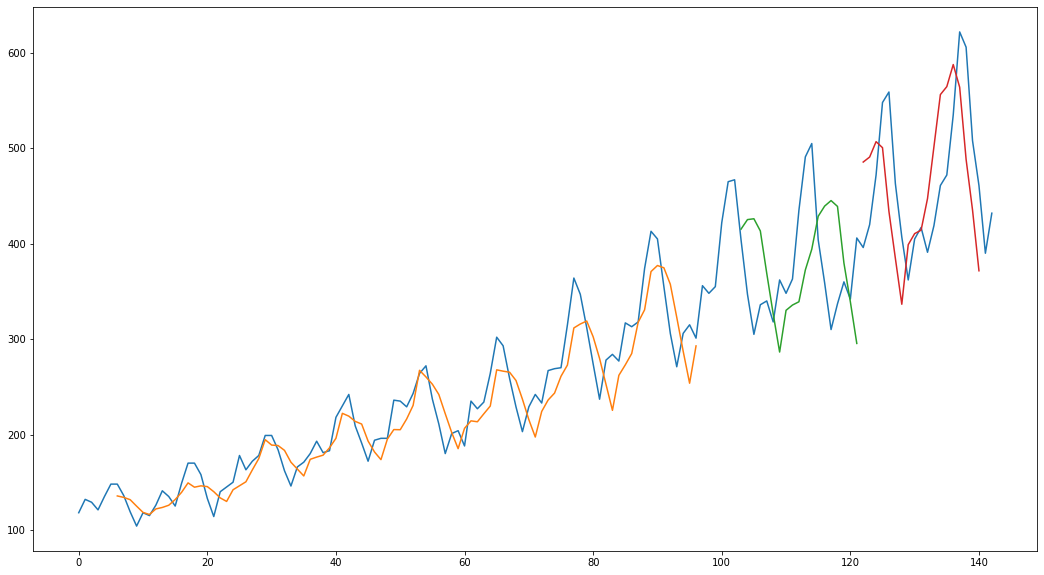

In [64]:
# shift train predictions for plotting
train_predict_plot = np.empty_like(passenger_number_array)
train_predict_plot[:, :] = np.nan
# reshape in order to fill only the training examples
train_predict_plot[input_window_size:len(predictions_for_train_denormalized)+input_window_size, :] = predictions_for_train_denormalized

# shift validation predictions for plotting
validation_predict_plot = np.empty_like(passenger_number_array)
validation_predict_plot[:, :] = np.nan
validation_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized), :] = predictions_for_val_denormalized

# shift test predictions for plotting
test_predict_plot = np.empty_like(passenger_number_array)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized):len(predictions_for_train_denormalized)+(2*input_window_size)+len(predictions_for_val_denormalized)+len(predictions_for_test_denormalized)] = predictions_for_test_denormalized


# plot baseline and predictions
fig = plt.figure(figsize=(18, 10))
plt.plot(passenger_number_array)
plt.plot(train_predict_plot)
plt.plot(validation_predict_plot)
plt.plot(test_predict_plot)
plt.show()